# Description of geoparsing files

This document describes the various output tables and how they interconnect. To provide an overview of the proceedure used to create these documents, first each publication's text is geoparsed to identify place names within the text. Then these place names are matched to shapefiles from natural earth to give them a spatial extent. These shapefiles and corresponding document matches are binned to a common spatial grid of a given resolution (2.5 degrees). 

The variable plotted is the number of articles per grid cell. You can plot this raw value, but what I find more informative is the weighted value. This tries to mitigate for articles referencing a large place (e.g. "the USA") covering up the signal of articles matching smaller places. To do this, for each unique document x place combination, I calculated a cell weight = 1/(the number of grid cells covered by that place). This value is then attributed to all the grid cells matching that document x place combination. In other words, the value in each grid cell displays a fraction of the total area covered by that match. All the resulting weighted values for each grid cell are then summed. For example, for a given place name match in a document (e.g. USA), each cell in the USA will be given a match to that document x place combination. 

In [1]:
import pandas as pd
import os

## Tables: geoparsed-text folder

All the csv files within the geoparsed-text folder contain the place information that was extracted from the text in each document using the geoparsing function in Mordecai. Each row represents a unique document x place combination.

Each row has the following unique identifier(s) that can be used to join/merge with other tables
- "analysis_id": A unique integer identifying the unique document
- "duplicate_id": Analagous to analysis_id -- don't worry about this one too much

The dataframe contains the following relevant columns as metadata:
- "title": The title of the study
- "word": The word identified within the title/abstract text that indicates a place name
- "spans": Where in the text the word was located
- "country_predicted", "country_conf": which country the word was predicted in, and with what confidence
- "lat", "lon": the latitude and longitude of the centroid of the place
- "geonameid": the corresponding ID from the geonames database
- "place_name": the corresponding place name from the geonames database

In [2]:
## Load in geoparsed location data

# Set the directory path where your CSV files are located
directory_path = '/home/dveytia/test-mordecai/outputs/geoparsed-text' # change file path
dfs = [] # initialise empty list

# Loop through all files in the directory and load
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        # Read each CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all DataFrames in the list into one
places = pd.concat(dfs, ignore_index=True)
places = places.drop_duplicates(["id","geonameid"]) 
places = places.rename(columns={"id": "analysis_id"})
print(places.shape)
places.head(2)

(44127, 15)


,analysis_id,duplicate_id,title,word,spans,country_predicted,country_conf,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code
0,369746,1997.4164,Study on multi-function ocean thermal energy c...,Fiji,"[{'start': 783, 'end': 787}]",FJI,0.946707,NaN,-18.0000,178.000,FJI,2205218,Republic of Fiji,A,PCLI
1,369760,1997.4175,Role of sewage phosphorus in coastal water ene...,Tuticorin,"[{'start': 133, 'end': 142}]",IND,0.952811,Tamil Nadu,8.8375,77.963,IND,7627069,Thoothukkudi,A,ADM2


## Table: grid_df_res2.5.csv

This table contains the grid information that the geoparsed text locations and natural earth shapefiles are binned to. 

Each row has the following unique identifier(s) that can be used to join/merge with other tables
- "grid_df_id": A unique integer identifying the grid cell. 

The dataframe contains the following columns as metadata:
- "LAT" and "LON": a unique latitude (LAT) and longitude (LON) corresponding to the unique grid cell (grid_df_id)
- "area_km": The area of this grid cell in km2
- "is_land": a logical vector indicating whether the grid cell is on land (True) or not (False)

In [3]:
grid_df = pd.read_csv(f'/home/dveytia/test-mordecai/outputs/grid_df_res2.5.csv', low_memory=False) # the grid
print(grid_df.head())

     LAT     LON  grid_df_id      area_km  is_land
0 -88.75 -178.75           0  1685.654015    False
1 -88.75 -176.25           1  1685.654015    False
2 -88.75 -173.75           2  1685.654015    False
3 -88.75 -171.25           3  1685.654015    False
4 -88.75 -168.75           4  1685.654015    False


## Table: shp_df_natural-earth-shapes.csv

This table contains the polygon information for the natural earth shapefiles. There are over 100 rows of metadata, so I will not go into all of them and just describe the most relevant.

Each row has the following unique identifier(s) that can be used to join/merge with other tables
- "shpfile_id": A unique integer identifying the shapefile

The dataframe contains the following columns as metadata:
- 'area_km2': the area in km2 of the shapefile

## Table: shp_grid_df.csv

A table containing the grid cells matching the coverage of each shapefile. If a shapefile did not have an extent and just a lat/lon, then the grid cell in which the centroid was closest to the lat/lon was matched.

Each row has the following unique identifier(s) that can be used to join/merge with other tables
- "shpfile_id": A unique integer identifying the shapefile
- "grid_df_id": A unique integer identifying the grid cell.

In [4]:
shp_grid_df = pd.read_csv(f'/home/dveytia/test-mordecai/outputs/shp_grid_df.csv', low_memory=False) # shapefiles matched to grid
print(shp_grid_df.head())

   shpfile_id  grid_df_id
0           0        4114
1           0        3971
2           0        4115
3           0        3972
4           0        4116


## Table: geoparsed-text_shp_df_matches.csv

This table contains information on which grid cells (grid_df_id) are covered by places (shp_id) that were identified within documents (analysis_id). These ids can be used to join with other tables to get more metadata if desired. For plotting, the most important metatdata variable is "cell_weight" which is described in the introduction above.  

In [5]:
shp_df_matches = pd.read_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_shp_df_matches.csv", low_memory=False) # text match to shapefiles
print(shp_df_matches.head())

   grid_df_id  analysis_id  shp_id                place  cell_weight
0        6095     284452.0   232.0  antigua and barbuda         0.25
1        7568     284452.0   232.0  antigua and barbuda         0.25
2        6725     284452.0   232.0  antigua and barbuda         0.25
3        9241     284452.0   232.0  antigua and barbuda         0.25
4        6095     358945.0   232.0  antigua and barbuda         0.25


## Table: geoparsed-text_grid-sums.csv

Using the previous table, this table has calculated the number of articles per unique grid cell (grid_df_id), both unweighted (n_articles) and weighted (n_articles_weighted). Some metadata on the grid cell (LON, LAT, area_km, is_land) are also included for easy plotting


In [6]:
shp_df_sum_grid = pd.read_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_grid-sums.csv")
print(shp_df_sum_grid.head())

     LAT     LON  grid_df_id      area_km  is_land  n_articles  \
0 -88.75 -178.75           0  1685.654015    False         0.0   
1 -88.75 -176.25           1  1685.654015    False         0.0   
2 -88.75 -173.75           2  1685.654015    False         0.0   
3 -88.75 -171.25           3  1685.654015    False         0.0   
4 -88.75 -168.75           4  1685.654015    False         0.0   

   n_articles_weighted  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  


# Example plots

In [7]:
## Load plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colormaps
import matplotlib as mpl

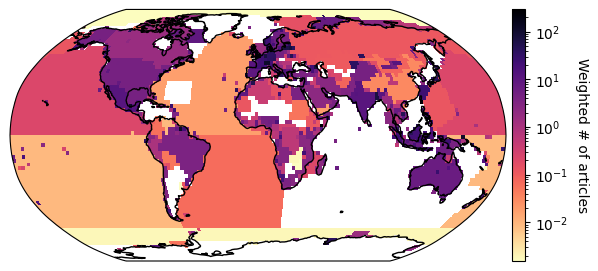

In [8]:
## Plot of all articles using the weighted sum

# Read in the data    
shp_df_sum_grid = pd.read_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_grid-sums.csv")
gridlons = shp_df_sum_grid.LON.unique()
gridlats = shp_df_sum_grid.LAT.unique()
shape = (len(gridlats), len(gridlons))
n = np.array(shp_df_sum_grid.n_articles_weighted).reshape(shape)


# set up a map
fig=plt.figure()
ax = plt.axes(projection=ccrs.Robinson())

# Can use the regular grid lons and lats with the shading ='nearest' option
im = plt.pcolormesh(gridlons, gridlats, n, shading = 'nearest',
              cmap=colormaps['magma_r'], norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree()) 

ax.coastlines()

## Colourbar
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Weighted # of articles', rotation=270)

# Save
plt.show()


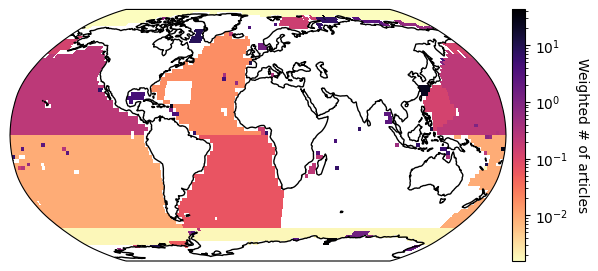

In [9]:
## Plot of ONLY articles in the ocean only using the weighted sum

# Read in the data    
shp_df_sum_grid = pd.read_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_grid-sums.csv")

# Set everything on land to 0
shp_df_sum_grid_ocean = shp_df_sum_grid
shp_df_sum_grid_ocean.loc[shp_df_sum_grid_ocean['is_land'] == True, 'n_articles_weighted'] = 0

# Format into grid
gridlons = shp_df_sum_grid_ocean.LON.unique()
gridlats = shp_df_sum_grid_ocean.LAT.unique()
shape = (len(gridlats), len(gridlons))
n = np.array(shp_df_sum_grid_ocean.n_articles_weighted).reshape(shape)

# set up a map
fig=plt.figure()
ax = plt.axes(projection=ccrs.Robinson())

# Can use the regular grid lons and lats with the shading ='nearest' option
im = plt.pcolormesh(gridlons, gridlats, n, shading = 'nearest',
              cmap=colormaps['magma_r'], norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree()) 

ax.coastlines()

## Colourbar
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Weighted # of articles', rotation=270)

plt.show()